# 简介

参考论文[https://arxiv.org/abs/1311.2901](https://arxiv.org/abs/1311.2901)

* CNN作为一个著名的深度学习领域的“黑盒”模型，已经在计算机视觉的诸多领域取得了极大的成功，但是，至今没有人能够“打开”这个“黑盒”，从数学原理上予以解释。这对理论研究者，尤其是数学家来说当然是不可接受的，但换一个角度来说，我们终于创造出了无法完全解释的事物，这也未尝不是一种进步了！
* 当然，虽然无法完全“打开”这个“黑盒”，但是仍然出现了很多探索这个“黑盒”的尝试工作。其中一个工作就是今天我们讨论的重点：可视化CNN模型，这里的可视化指的是可视化CNN模型中的卷积核。
* 跟随我一起搭建网络，实现配置可视化结构，你将在训练过程中看到卷积神经网络对特征的提取过程

# 可视化并理解卷积神经网络（CNN）

![](https://ai-studio-static-online.cdn.bcebos.com/532f20e95fe446fcabc9e65fbe9ab32e85beb11c67a940b1b75679d600e1cb36)



可视化工作分为两大类:
1. 一类是非参数化方法:这种方法不分析卷积核具体的参数，而是先选取图片库，然后将图片在已有模型中进行一次前向传播，对某个卷积核，我们使用对其响应最大的图片块来对之可视化;

2. 而另一类方法着重分析卷积核中的参数，使用参数重构出图像。

**这里我们实现第1类可视化方法，通过对网络中深层的特征图进行反向卷积，反向池化来可视化卷积神经网络的感知结构**

![](https://ai-studio-static-online.cdn.bcebos.com/bb00d2ddca2c4e1e8b9f17760763b24dcdece26763164fc0b1dbc13baa05f50a)


# 反卷积层实现
为了了解卷积操作，我们需要首先了解中间层的特征激活值。我们使用了一种新的方式将这些激活值映射回输入像素空间，表明了什么样的输入模式将会导致feature map中一个给定的激活值。我们使用反卷积网络来完成映射。一个反卷积网络可以被看成是一个卷积模型，这个模型使用和卷积同样的组件(过滤和池化)，但是却是相反的过程，因此是将特征映射到像素。在中，反卷积网络被提出作为一种进行非监督学习的方法，但是在这里，它没有学习能力，仅仅用来探测一个已经训练好的卷积神经网络。
1. 获取对应卷积层的参数(卷积核)shape为(NCHW)，并且将卷积核转置(NCHW-->NCWH),也就是高和宽互换，原理请参考神经网络的反向传播
2. 使用`fluid.dygraph.Conv2DTranspose()`动态图API创建反卷积层，并且用获得参数初始
3. 进行反卷积

**特征图的可视化**

一般的RGB图像像素取值范围为0-255，但在网络中的数据不一定会在这个范围内，它可能更接近(-1, 1)、(-10, 10)...

所以我们需要编写一个函数，使其可以拉伸图像像素取值范围，尽可能接近0-255取值范围。
我们要处理一个取值在未知范围的数组，其shape为C, H, W（一般2D卷积后的特征图像格式为NCHW，N代表Batch Size，C为通道数/卷积的num_filters，H和W则为长宽,这里我们取单批数据）
**获取这个数组的取值范围并设计算法进行拉伸**
假定取值范围在(-1, 4)，我们要将其等比例变成(0, 255)取值范围
算法部分可以用一张图来解释

![](https://ai-studio-static-online.cdn.bcebos.com/6ca9c56c4ba347d895f1b8766ed3f9e33456563e5ffa4f32851fbbd8644f3046)

这是单通道的像素拉伸，在“猫十二分类”中，这里的单通道特征图像可能会是一只猫耳朵、一个猫爪...
* 将single_featuremap_display设置为True，则可以显示指定数目的单通道特征图
* 将single_featuremap_display设置为False，则会将指定数目的特征图进行通道合并，显示的是一张融合特征图

**实现代码如下：**

In [ ]:
#猫十二分类（动态图）
#导入需要的包
import os,sys,time
import paddle.fluid as fluid
import numpy as np
import cv2
import matplotlib.pylab as plt
from PIL import Image
#本次训练的参数
train_paramters={
    'train_image_list':'train_list.txt',      #训练数据的标注文件
    'test_image_dir':'cat_12_test',           #测试数据集
    'batch_size':32,                          #批大小
    'epoch_num':40,
    'save_model_name':'Cat_2_classes12'       #训练的轮数
}

#反卷积实现
class Reverse_Conv:
    def __init__(self,layername,display_featuremaps_num,\
    layer,num_channels,num_filters,filter_size,\
    single_featuremap_display=False,stride=1,padding=1,act='relu'):
        '''
        layername：显示特征图时自定义的名称
        display_featuremaps_num:要可视化的featuremap的数量
        layer:卷积层对应的反卷积层
        param：反卷积网络的参数
        num_channels：通道数，比数据格式是NCHW,那么num_channels=C
        filter_size,num_filters:反卷积API的参数
        featuremaps:shape为(featuremaps_num,H,W)
        single_featuremap_display:是否显示每个featuremap
        '''
        self.param = (np.transpose(layer.parameters()[0].numpy(),(0,1,3,2)))   #获得对应层卷积参数，并且转置（NCHW-->NCWH）作为新参数
        self.num_channels = num_channels
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        self.act = act

        self.title = layername
        self.featuremaps_num = display_featuremaps_num
        self.single_featuremap_display = single_featuremap_display
    
    def reverse_conv(self,rx):
        '''
        创建反卷积层
        输入数据进行反卷积
        rx：NCHW格式的featuremap
        '''
        reverse_conv = fluid.dygraph.Conv2DTranspose(num_channels=self.num_channels,num_filters=self.num_filters,\
        filter_size=self.filter_size,stride=self.stride,padding=self.padding,act=self.act,\
        param_attr=fluid.initializer.NumpyArrayInitializer(self.param))
        rx=reverse_conv(rx)
        if(self.featuremaps_num>0):
            self.featuremaps = rx[0].numpy()
            self.concat_featuremaps()
        return rx

    def fix_value(self,img_pixs):#像素拉伸
        '''
        img_pixs:featuremap的像素矩阵
        '''
        pix_max=np.max(img_pixs)#取最大像素
        pix_min=np.min(img_pixs)#取最小像素
        pix_range=np.abs(pix_max)+np.abs(pix_min)#获取像素距离
        if(pix_range==0): #如果所有值都是零则直接返回（下面不能除以零）
            return img_pixs
        pix_rate = 255/pix_range#获取像素缩放倍率
        pix_left = pix_min*pix_rate#获取最小还原像素值
        img_pixs = img_pixs*pix_rate-pix_left#整体像素值平移
        img_pixs[np.where(img_pixs<0)]=0. #增加鲁棒性，检查超出区间的像素值，np.where(a<x)与a<x等同
        img_pixs[np.where(img_pixs>255)]=255.
        return img_pixs
        
    def concat_featuremaps(self):
        '''
        featuremaps可视化
        输入(CHW)的特征图，使其显示
        '''
        count=0
        for featuremap in self.featuremaps:
            if count>self.featuremaps_num:#超过指定数量就结束
                break
            if count==0:
                featuremap = self.fix_value(featuremap)#像素拉伸
                total_featuremaps = featuremap
            else:
                featuremap = self.fix_value(featuremap)
                total_featuremaps += featuremap #通道合并
            count+=1
            if(self.single_featuremap_display):#单独显示一张featuremap
                single_featuremap = Image.fromarray(np.asarray(featuremap).astype('uint8')).convert('RGB')
                plt.imshow(single_featuremap)
                plt.title('featuremap'+str(count)+' of '+self.title)
                plt.show()
                time.sleep(0.2)
        total_featuremaps = self.fix_value(total_featuremaps) #再次矫正像素取值范围
        total_featuremaps = Image.fromarray(np.asarray(total_featuremaps).astype('uint8')).convert('RGB')
        plt.imshow(total_featuremaps)
        plt.title('total_featuremap of '+self.title)
        plt.show()

2020-07-28 11:12:35,653-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-07-28 11:12:35,993-INFO: generated new fontManager


# 反池化层的实现

我们可以通过正向传播时记录池化时最大值位置。
在反池化的时候，只把池化过程中最大激活值所在的位置坐标的值激活，其它的值置为0
过程如下图所示:
![](https://ai-studio-static-online.cdn.bcebos.com/c0228f8f2bb54004b724a40f053f20a977ae09241fe4497fbfcbc7d8fc158e52)

**maxpool需要记录池化之前最大值的位置**：

**im2col**

im2col函数 会考虑滤波器大小、步幅、填充，将输入数据展开为 2 维数组。池化的情况下，在通道方向上是独立的。具体地讲，如下图所示，池化的应用区域按通道单独展开。
像这样展开之后，只需对展开的矩阵求各行的最大值，并转换为合适的形状即可

* 将特征图按池化的大小展开成(-1,pool_h*pool_w ) 的形状（这里只论单张特征图），每行就是一池化的应用区域
* 记录每行最大值的位置argmax
* 反池化时把特征图的值赋值到0矩阵argmax位置

**具体思路如下图**

![](https://ai-studio-static-online.cdn.bcebos.com/b22201dda72a453fa63819abe416db7e8236acadc52241f890a4633af34e164d)

**实现代码如下：**

In [ ]:
class Reverse_Pooling:
    def __init__(self,temp_data,pool_h,pool_w,stride=1,pad=0):
        '''
        temp_data:用于获取最大值索引，池化之前的数据
        '''
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.temp_data = temp_data.numpy()

    def im2col(self,input_data):
        """
        input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
        -------
        col : 2维数组
        """
        filter_h = self.pool_h
        filter_w = self.pool_w
        stride = self.stride
        pad = self.pad

        N, C, H, W = input_data.shape 
        out_h = (H + 2*pad - filter_h)//stride + 1  #计算池化之后的H,W
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant') #进行边填充，padding
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))    #创建池化输出

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1) 
        return col

    def col2im(self,col):
        """
        col :col : 2维数组(展开的池化层)
        input_shape : 输入数据的形状（例：(10, 1, 28, 28)）
        """

        filter_h = self.pool_h
        filter_w = self.pool_w
        stride = self.stride
        pad = self.pad
        input_shape=self.x.shape
        N,C,H,W = input_shape
        out_h=(H+2*pad-filter_h)//stride+1
        out_w=(W+2*pad-filter_w)//stride+1
        col=col.reshape(N,out_h,out_w,C,filter_h,filter_w).transpose(0,3,4,5,1,2)

        img=np.zeros((N,C,H+2*pad+stride-1,W+2*pad+stride-1))
        for y in range(filter_h):

            y_max = y+stride*out_h
            for x in range(filter_w):
                x_max = x +stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]

    def forward(self):
        x=self.temp_data
        N,C,H,W = x.shape
        out_h = int(1+(H-self.pool_h)/self.stride)  #计算池化后的H,W
        out_w = int(1+(W-self.pool_w)/self.stride)
        #展开（1）
        col = self.im2col(x)  #所有特征图展开展开成(N,C,H*W)
        col = col.reshape(-1,self.pool_h*self.pool_w)  #(N,C,H*W)-->(N*C,H*W)
        #最大值（2）
        out = np.max(col,axis=1)
        #取最大值坐标反向池化用
        arg_max = np.argmax(col,axis=1)  
        self.x = x
        self.arg_max = arg_max

    def backward(self,dout):
        self.forward()
        dout = dout.numpy()       
        dout = dout.transpose(0,2,3,1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size,pool_size)) #创建反池化输出
        dmax[np.arange(self.arg_max.size),self.arg_max.flatten()] = dout.flatten()  #对输出按索引赋值
        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.col2im(dcol)
        dx=fluid.dygraph.to_variable(dx.astype('float32'))

        return dx

**通过猫十二分类来了解卷积神经网络的特征学习**

这里我们使用百度飞桨深度学习框架的猫十二分类数据集，看看卷积神经网络是如何学习到猫的特征的

![](https://ai-studio-static-online.cdn.bcebos.com/ad854fa2f4e5406cb2979b525e8e6695615ec36f203046058f2adebdff5fbdd5)


**解压数据集文件**

**fork本项目后在终端粘贴下面命令（建议用GPU环境，CPU很慢哦）**

终端输入命令：
```
unzip data/data10954/cat_12_test.zip 
unzip data/data10954/cat_12_train.zip
```
训练集一共2161张猫脸图片，总共分为12类猫脸，并且训练集已经把标注放在train_list.txt文件中

如图所示，前面是图片PATH，后面是标签(有些图片不可读，我已经删除)

![](https://ai-studio-static-online.cdn.bcebos.com/7b8854724aef4c1dbbfa5a8ba719fa8c76c4c2d2770c47f6878ff8c503003d64)


# 定义分类网络
VGG16网络

![](https://ai-studio-static-online.cdn.bcebos.com/c147b1a775eb4d8fbed2291f2446ce2c569377a7b17a4516af73d75ab1497578)


上图中，每一列对应一种结构配置。
重点看D类配置，包含：
* 13个卷积层（Convolutional Layer）
* 3个全连接层（Fully connected Layer）
* 5个池化层（Pool layer）,分别用maxpool表示

其中，卷积层和全连接层具有权重系数，因此也被称为权重层，总数目为13+3=16，这即是

VGG16中16的来源。(池化层不涉及权重，因此不属于权重层，不被计数)。

**这里我们将全连接层简化，全局池化（global pooling）后直接softmax输出12个类的概率**

* “global pooling”就是pooling的 滑窗size 和整张feature map的size一样大。这样，每个 W×H×C 的feature map输入就会被转化为 1×1×C输出
* 全局池化取代全连接层可以大大减少我们需要训练的参数



In [ ]:
class VGG16net(fluid.dygraph.Layer):
    def __init__(self):
        super(VGG16net,self).__init__()
        #这里可以使用循环，我没有用，是为了调整网络的时候方便，网络更直观，方便大家理解
        self.block1_conv1_3_64=fluid.dygraph.Conv2D(num_channels=3,num_filters=64,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block1_conv2_3_64=fluid.dygraph.Conv2D(num_channels=64,num_filters=64,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block1_maxpool1=fluid.dygraph.Pool2D(pool_size=(2,2),pool_stride=2,pool_padding=0,pool_type='max')
        self.block2_conv1_3_128=fluid.dygraph.Conv2D(num_channels=64,num_filters=128,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block2_conv2_3_128=fluid.dygraph.Conv2D(num_channels=128,num_filters=128,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block2_maxpool1=fluid.dygraph.Pool2D(pool_size=(2,2),pool_stride=2,pool_padding=0,pool_type='max')
        self.block3_conv1_3_256=fluid.dygraph.Conv2D(num_channels=128,num_filters=256,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block3_conv2_3_256=fluid.dygraph.Conv2D(num_channels=256,num_filters=256,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block3_conv3_3_256=fluid.dygraph.Conv2D(num_channels=256,num_filters=256,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block3_maxpool1=fluid.dygraph.Pool2D(pool_size=(2,2),pool_stride=2,pool_padding=0,pool_type='max')
        self.block4_conv1_3_512=fluid.dygraph.Conv2D(num_channels=256,num_filters=512,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block4_conv2_3_512=fluid.dygraph.Conv2D(num_channels=512,num_filters=512,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block4_conv3_3_512=fluid.dygraph.Conv2D(num_channels=512,num_filters=512,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block4_maxpool1=fluid.dygraph.Pool2D(pool_size=(2,2),pool_stride=2,pool_padding=0,pool_type='max')
        self.block5_conv1_3_512=fluid.dygraph.Conv2D(num_channels=512,num_filters=512,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block5_conv2_3_512=fluid.dygraph.Conv2D(num_channels=512,num_filters=512,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block5_conv3_3_512=fluid.dygraph.Conv2D(num_channels=512,num_filters=512,filter_size=(3,3),stride=1,padding=1,act='relu')
        self.block5_maxpool1=fluid.dygraph.Pool2D(global_pooling=True,pool_type='max')  #全局池化层
        self.fc1=fluid.dygraph.Linear(input_dim=512,output_dim=12,act='softmax')

    def normal_fward(self,x):
        '''
        用于不需要show featuremap 的训练过程
        '''
        x=self.block1_conv1_3_64(x)
        x=self.block1_conv2_3_64(x)
        x=self.block1_maxpool1(x)
        x=self.block2_conv1_3_128(x)
        x=self.block2_conv2_3_128(x)
        x=self.block2_maxpool1(x)
        x=self.block3_conv1_3_256(x)
        x=self.block3_conv2_3_256(x)
        x=self.block3_conv3_3_256(x)
        x=self.block3_maxpool1(x)
        x=self.block4_conv1_3_512(x)
        x=self.block4_conv2_3_512(x)
        x=self.block4_conv3_3_512(x)
        x=self.block4_maxpool1(x)
        x=self.block5_conv1_3_512(x)
        x=self.block5_conv2_3_512(x)
        x=self.block5_conv3_3_512(x)
        x=self.block5_maxpool1(x)
        x=fluid.layers.squeeze(x,axes=[])    #多余的维度去除(32,1,1,512)-->(32,512)
        x=self.fc1(x)
        return x

    def Reverse_forward(self,x):
        '''
        正向传播之后，反向卷积并且显示特征图
        '''
        x=self.block1_conv1_3_64(x)
        x=self.block1_conv2_3_64(x)
        block1_maxpool1_temp=x
        x=self.block1_maxpool1(x)
        x=self.block2_conv1_3_128(x)
        x=self.block2_conv2_3_128(x)
        block2_maxpool1_temp=x
        x=self.block2_maxpool1(x)
        x=self.block3_conv1_3_256(x)
        x=self.block3_conv2_3_256(x)
        x=self.block3_conv3_3_256(x)
        block3_maxpool1_temp=x
        x=self.block3_maxpool1(x)
        x=self.block4_conv1_3_512(x)
        x=self.block4_conv2_3_512(x)
        x=self.block4_conv3_3_512(x)
        block4_maxpool1_temp=x
        x=self.block4_maxpool1(x)
        x=self.block5_conv1_3_512(x)
        x=self.block5_conv2_3_512(x)
        x=self.block5_conv3_3_512(x)
        
        #反向卷积，池化
        rblock5_conv3 = Reverse_Conv('block5_conv3',512,self.block5_conv3_3_512,512,512,3)
        rx = rblock5_conv3.reverse_conv(x)
        rblock5_conv2 = Reverse_Conv('block5_conv2',512,self.block5_conv2_3_512,512,512,3)
        rx = rblock5_conv2.reverse_conv(rx)
        rblock5_conv1 = Reverse_Conv('block5_conv1',512,self.block5_conv1_3_512,512,512,3)
        rx = rblock5_conv1.reverse_conv(rx)
        rblock4_maxpool = Reverse_Pooling(block4_maxpool1_temp,2,2,2,0)
        rx = rblock4_maxpool.backward(rx)
        rblock4_conv3 = Reverse_Conv('block4_conv3',512,self.block4_conv3_3_512,512,512,3)
        rx = rblock4_conv3.reverse_conv(rx)
        rblock4_conv2 = Reverse_Conv('block4_conv2',512,self.block4_conv2_3_512,512,512,3)
        rx = rblock4_conv2.reverse_conv(rx)
        rblock4_conv1 = Reverse_Conv('block4_conv1',256,self.block4_conv1_3_512,512,256,3)
        rx = rblock4_conv1.reverse_conv(rx)
        rblock3_maxpool = Reverse_Pooling(block3_maxpool1_temp,2,2,2,0)
        rx = rblock3_maxpool.backward(rx)
        rblock3_conv3 = Reverse_Conv('block3_conv3',256,self.block3_conv3_3_256,256,256,3)
        rx = rblock3_conv3.reverse_conv(rx)
        rblock3_conv2 = Reverse_Conv('block3_conv2',256,self.block3_conv2_3_256,256,256,3)
        rx = rblock3_conv2.reverse_conv(rx)
        rblock3_conv1 = Reverse_Conv('block3_conv1',256,self.block3_conv1_3_256,256,128,3)
        rx = rblock3_conv1.reverse_conv(rx)
        rblock2_maxpool = Reverse_Pooling(block2_maxpool1_temp,2,2,2,0)
        rx = rblock2_maxpool.backward(rx)
        rblock2_conv2 = Reverse_Conv('block2_conv2',128,self.block2_conv2_3_128,128,128,3)
        rx = rblock2_conv2.reverse_conv(rx)
        rblock2_conv1 = Reverse_Conv('block2_conv1',128,self.block2_conv1_3_128,128,64,3)
        rx = rblock2_conv1.reverse_conv(rx)
        rblock1_maxpool = Reverse_Pooling(block1_maxpool1_temp,2,2,2,0)
        rx = rblock1_maxpool.backward(rx)
        rblock1_conv2 = Reverse_Conv('block1_conv2',64,self.block1_conv2_3_64,64,64,3)
        rx = rblock1_conv2.reverse_conv(rx)
        rblock1_conv1 = Reverse_Conv('block1_conv1',64,self.block1_conv1_3_64,64,3,3)
        rx = rblock1_conv1.reverse_conv(rx)

        x=self.block5_maxpool1(x)
        x=fluid.layers.squeeze(x,axes=[])
        x=self.fc1(x)
        return x

    def forward(self,x,is_display_feature=False):
        if is_display_feature:
            x = self.Reverse_forward(x)
        else:
            x = self.normal_fward(x)
        return x

# 读取数据

**数据读取函数↓**

In [ ]:
def data_load(train_list_path,batch_size):
    '''
    train_list_path:标注文件txt所在path
    '''
    train_dir_list=[]
    train_label=[]
    with open(train_list_path,'r') as train_dirs:
        #train_dir_list.append(train_dirs.readline())
        lines=[line.strip() for line in train_dirs]
        for line in lines:
            img_path,label=line.split()
            train_dir_list.append(img_path)
            train_label.append(label)
    def reader():
        imgs=[]
        labels=[]
        img_mask=np.arange(len(train_dir_list)) #生成索引
        np.random.shuffle(img_mask) #随机打乱索引
        count=0
        for i in img_mask:
            img=cv2.imread(train_dir_list[i])
            img=cv2.resize(img,(224,224),interpolation=cv2.INTER_CUBIC)/255
            img=np.transpose(img,(2,0,1))
            imgs.append(img)
            labels.append(train_label[i])
            count+=1
            if(count%train_paramters['batch_size']==0):
                yield np.asarray(imgs).astype('float32'),np.asarray(labels).astype('int64').reshape((train_paramters['batch_size'],1))
                imgs=[]
                labels=[]
    return reader

# 开始训练

**需要重头开始训练的话把保存的权重文件删除**

**每训练1000次输出一次特征图**

**训练完一轮就保存一次权重**

**训练40个epoch**



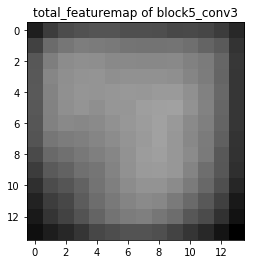

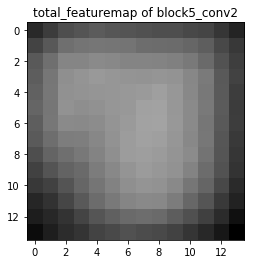

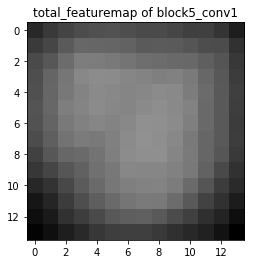

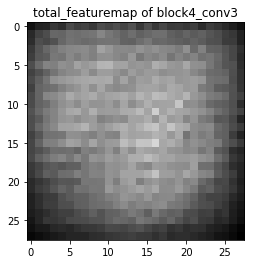

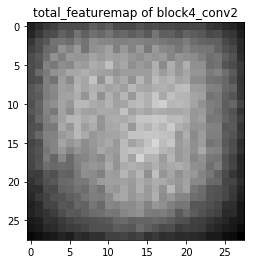

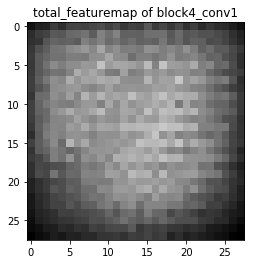

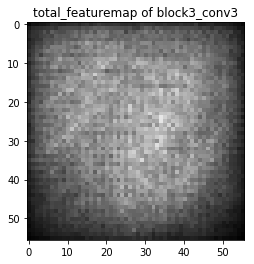

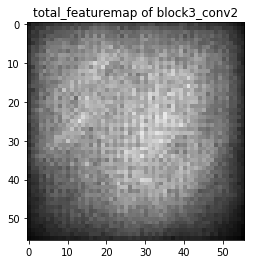

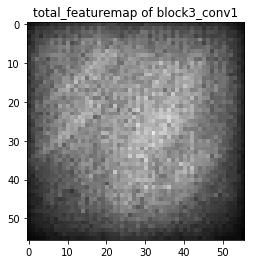

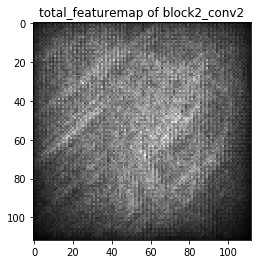

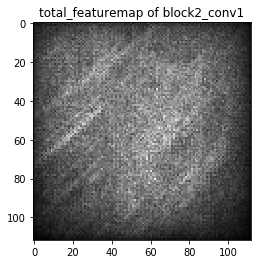

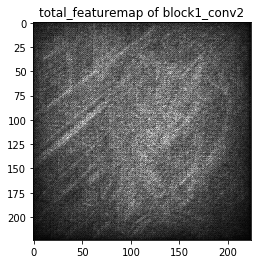

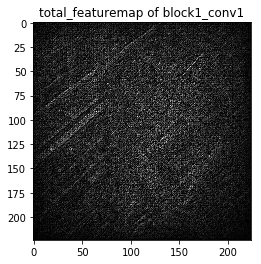

pass_epoch:0,iters:67,loss：2.4799280166625977,acc：0.125
pass_epoch:1,iters:134,loss：2.517878532409668,acc：0.0625
pass_epoch:2,iters:201,loss：2.3678321838378906,acc：0.125
pass_epoch:3,iters:268,loss：2.5074377059936523,acc：0.09375
pass_epoch:4,iters:335,loss：2.395510196685791,acc：0.09375
pass_epoch:5,iters:402,loss：2.3040196895599365,acc：0.3125
pass_epoch:6,iters:469,loss：2.318796157836914,acc：0.15625
pass_epoch:7,iters:536,loss：2.408168077468872,acc：0.1875
pass_epoch:8,iters:603,loss：2.1314830780029297,acc：0.25
pass_epoch:9,iters:670,loss：2.3354663848876953,acc：0.21875
pass_epoch:10,iters:737,loss：2.0989861488342285,acc：0.21875
pass_epoch:11,iters:804,loss：2.01800799369812,acc：0.34375
pass_epoch:12,iters:871,loss：2.064736843109131,acc：0.1875


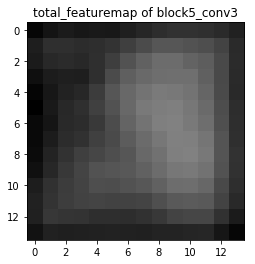

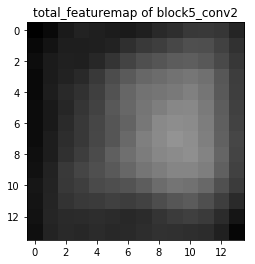

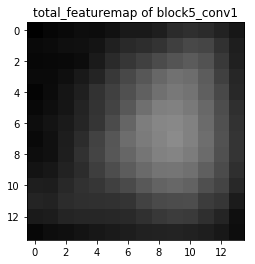

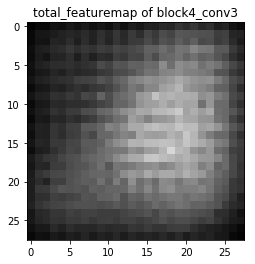

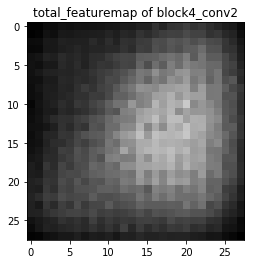

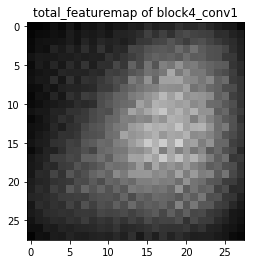

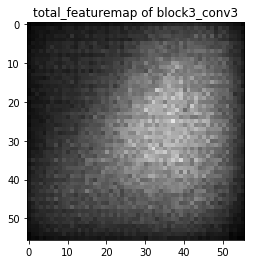

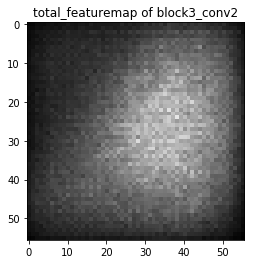

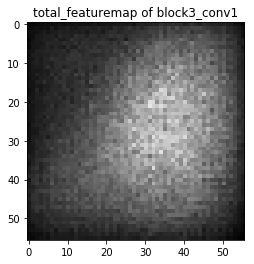

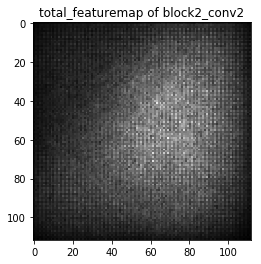

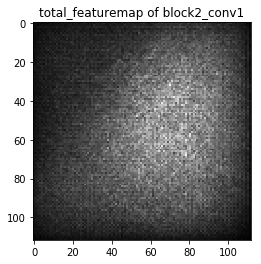

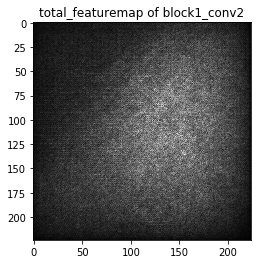

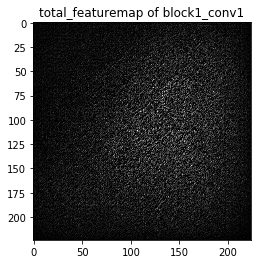

pass_epoch:13,iters:938,loss：1.6188513040542603,acc：0.46875
pass_epoch:14,iters:1005,loss：1.7495455741882324,acc：0.375
pass_epoch:15,iters:1072,loss：2.243290901184082,acc：0.15625
pass_epoch:16,iters:1139,loss：2.2192680835723877,acc：0.25
pass_epoch:17,iters:1206,loss：2.190603733062744,acc：0.25
pass_epoch:18,iters:1273,loss：1.7756171226501465,acc：0.375
pass_epoch:19,iters:1340,loss：2.0200839042663574,acc：0.34375
pass_epoch:20,iters:1407,loss：1.5426690578460693,acc：0.40625
pass_epoch:21,iters:1474,loss：1.4749078750610352,acc：0.5
pass_epoch:22,iters:1541,loss：0.8402727246284485,acc：0.75
pass_epoch:23,iters:1608,loss：1.150139331817627,acc：0.5625
pass_epoch:24,iters:1675,loss：1.0551210641860962,acc：0.53125
pass_epoch:25,iters:1742,loss：1.583927035331726,acc：0.40625


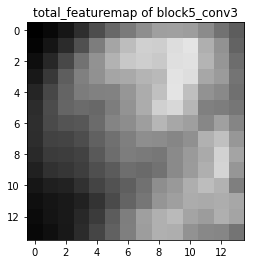

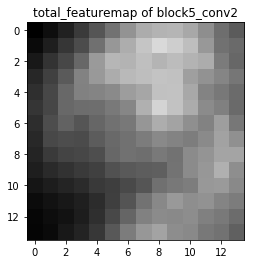

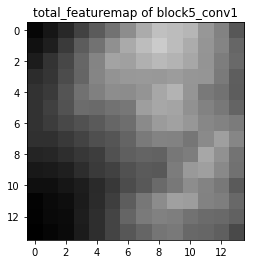

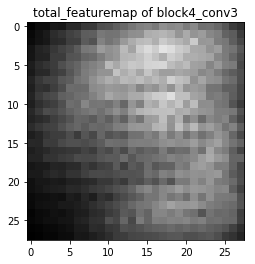

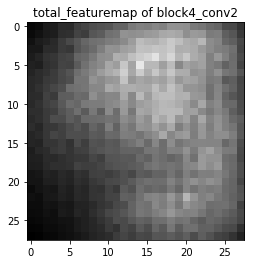

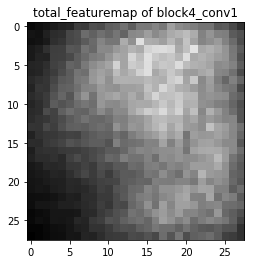

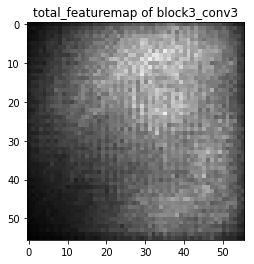

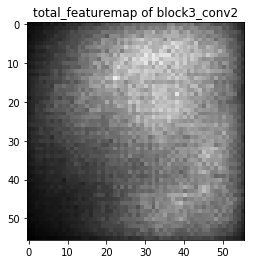

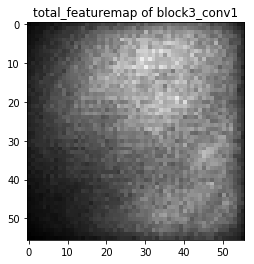

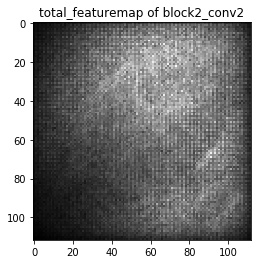

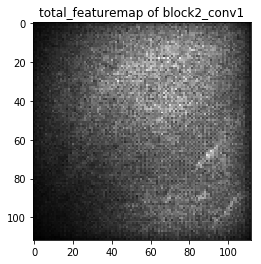

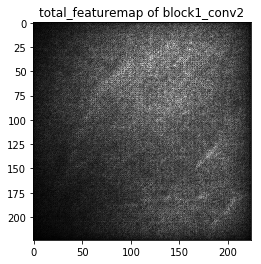

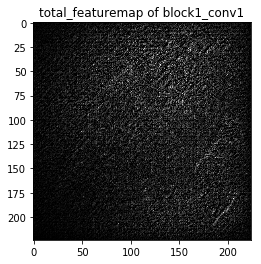

pass_epoch:26,iters:1809,loss：1.2691419124603271,acc：0.5
pass_epoch:27,iters:1876,loss：1.7214078903198242,acc：0.5
pass_epoch:28,iters:1943,loss：0.85252845287323,acc：0.71875
pass_epoch:29,iters:2010,loss：1.1482943296432495,acc：0.5625
pass_epoch:30,iters:2077,loss：0.7138460874557495,acc：0.84375
pass_epoch:31,iters:2144,loss：0.30972999334335327,acc：0.875
pass_epoch:32,iters:2211,loss：0.8071508407592773,acc：0.6875
pass_epoch:33,iters:2278,loss：1.2095224857330322,acc：0.71875
pass_epoch:34,iters:2345,loss：0.25210511684417725,acc：0.96875
pass_epoch:35,iters:2412,loss：0.707565188407898,acc：0.6875
pass_epoch:36,iters:2479,loss：0.47325584292411804,acc：0.90625
pass_epoch:37,iters:2546,loss：0.025728696957230568,acc：1.0
pass_epoch:38,iters:2613,loss：0.0027548810467123985,acc：1.0


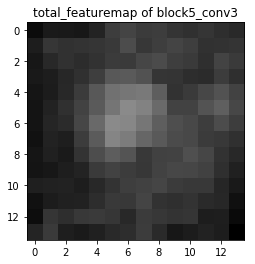

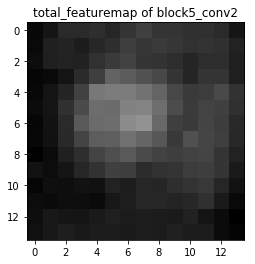

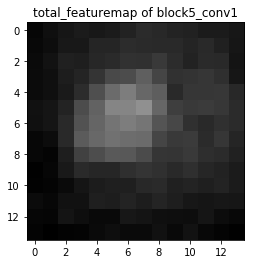

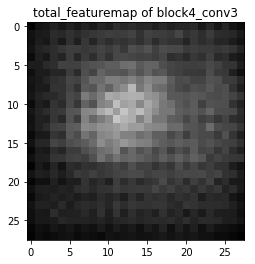

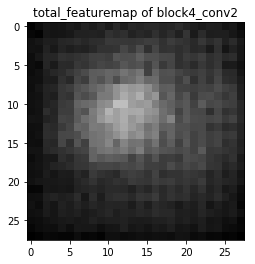

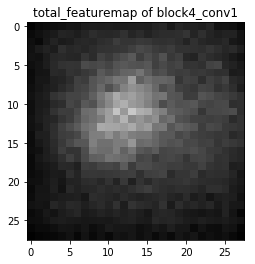

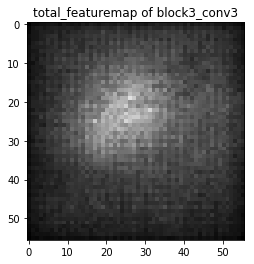

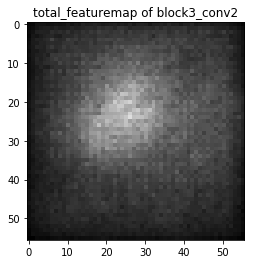

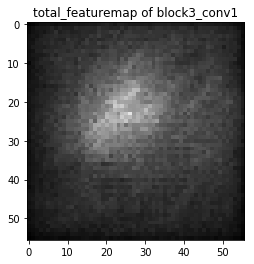

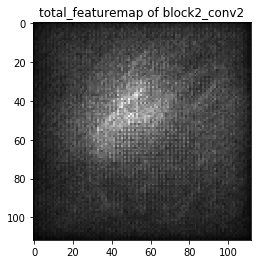

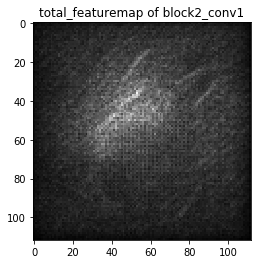

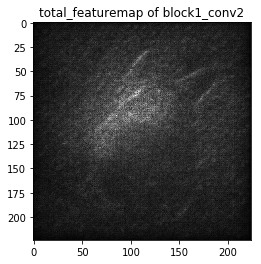

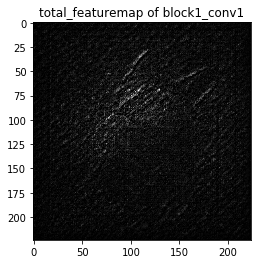

pass_epoch:39,iters:2680,loss：0.0015298365615308285,acc：1.0


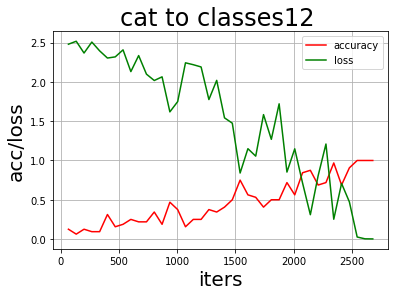

finished training


In [9]:


def draw_train_process(iters,accs,loss):
    '''
    训练可视化
    '''
    plt.title('cat to classes12 ',fontsize=24)
    plt.xlabel('iters',fontsize=20)
    plt.ylabel('acc/loss',fontsize=20)
    plt.plot(iters,accs,color='red',label='accuracy')
    plt.plot(iters,loss,color='green',label='loss')
    plt.legend()
    plt.grid()
    plt.show()

with fluid.dygraph.guard():
    train_loader=data_load(train_paramters['train_image_list'],train_paramters['batch_size'])
    model=VGG16net()  #实列化模型
    if os.path.exists(train_paramters['save_model_name']+'.pdparams'):#存在模型参数则继续训练
        print('continue training')
        param_dict,_=fluid.dygraph.load_dygraph(train_paramters['save_model_name'])
        model.load_dict(param_dict)
    model.train()
    is_display_feature=False
    all_iter=0
    all_loss=[]
    all_iters=[]
    all_accs=[]
    opt=fluid.optimizer.SGDOptimizer(learning_rate=0.01,parameter_list=model.parameters())
    for pass_num in range(train_paramters['epoch_num']):
        for pass_id,data in enumerate(train_loader()):
            images,labels = data
            images = fluid.dygraph.to_variable(images)
            labels = fluid.dygraph.to_variable(labels)
            if(all_iter%893==0):
                is_display_feature=True
                out = model(images,is_display_feature)
                is_display_feature=False
            else:
                out = model(images,is_display_feature)
            loss=fluid.layers.cross_entropy(label=labels,input=out)
            avg_loss=fluid.layers.mean(loss)
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_gradients()
            all_iter+=1
        #每训练完一个epoch（reader()）
        acc=fluid.layers.accuracy(input=out,label=labels)
        all_loss.append(avg_loss.numpy()[0])
        all_iters.append(all_iter)
        all_accs.append(acc.numpy()[0])
        print('pass_epoch:{},iters:{},loss：{},acc：{}'.format(pass_num,all_iter,avg_loss.numpy()[0],acc.numpy()[0]))
        fluid.save_dygraph(model.state_dict(),train_paramters['save_model_name']) #保存模型参数
    draw_train_process(all_iters,all_accs,all_loss)
    print('finished training')


# 模型评估与特征图

输出各层特征图（通道合并）

选用test数据集测试模型分类效果（test数据没标签，所以只能人工判断了）

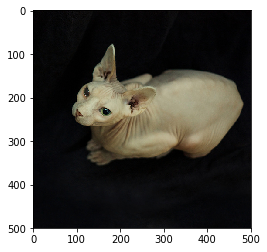

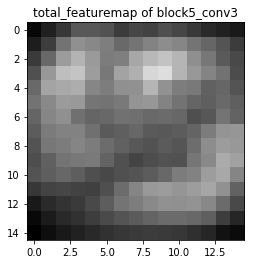

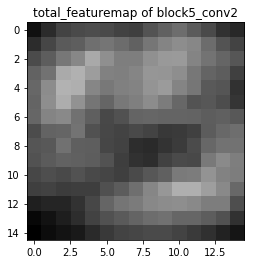

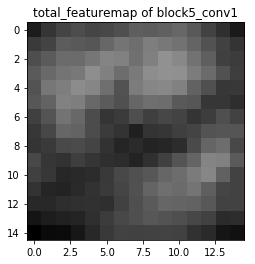

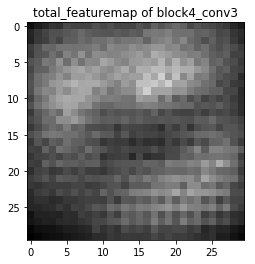

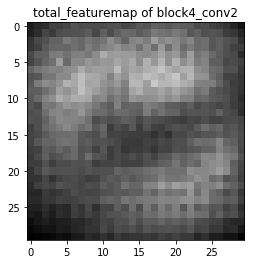

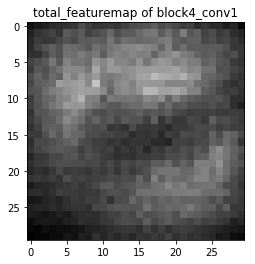

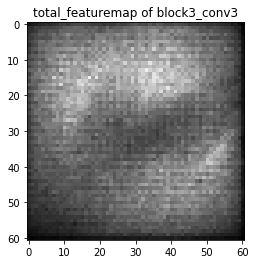

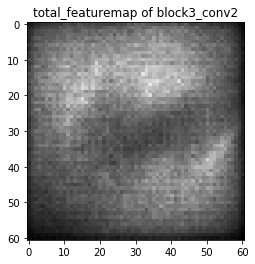

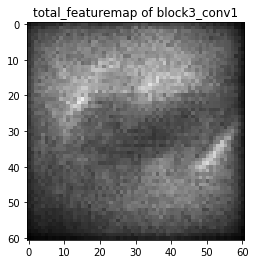

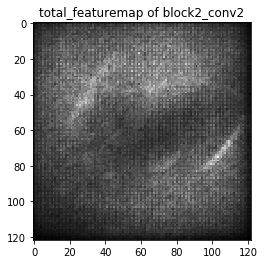

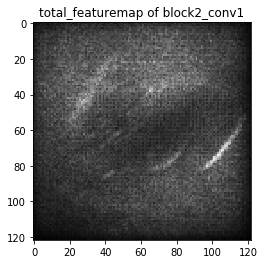

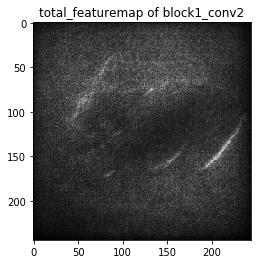

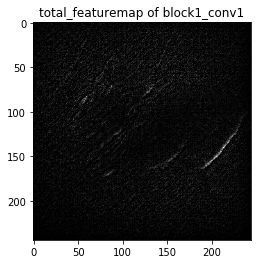

猫类别:0


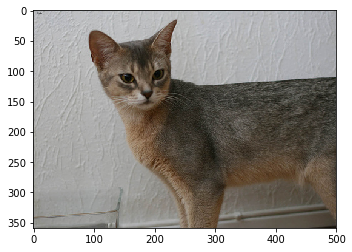

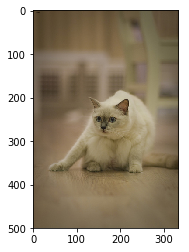

猫类别:1


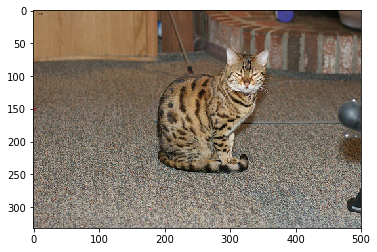

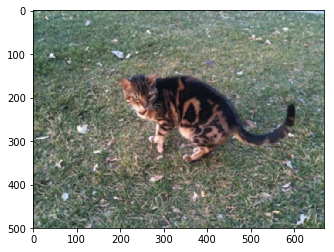

猫类别:2


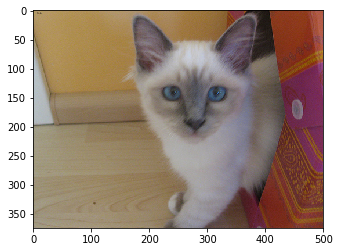

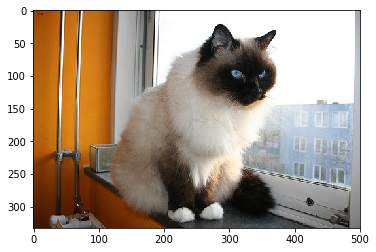

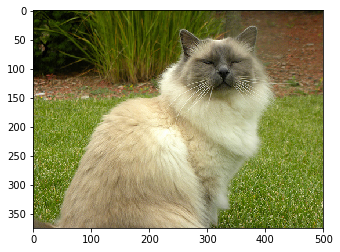

猫类别:3


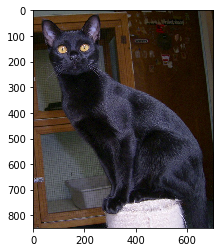

猫类别:4
没有这个类别的
猫类别:5


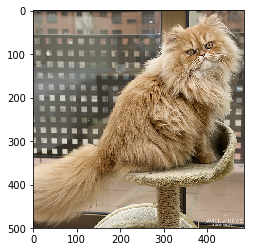

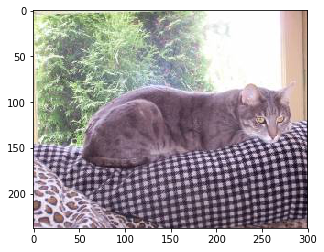

猫类别:6
没有这个类别的
猫类别:7
没有这个类别的
猫类别:8
没有这个类别的
猫类别:9


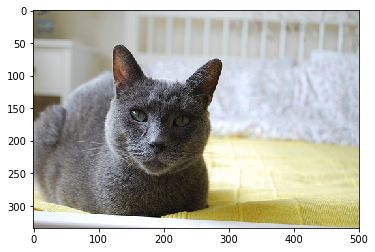

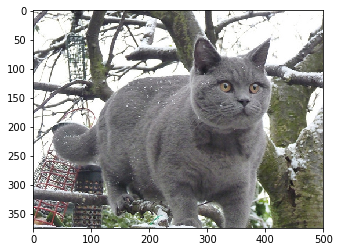

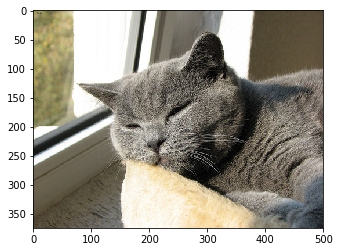

猫类别:10


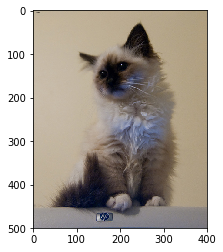

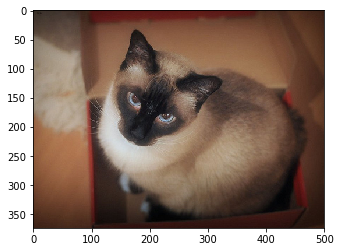

猫类别:11


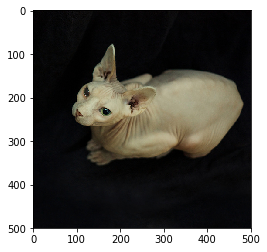

In [12]:

def reader_img(img_path):
    img=cv2.imread(img_path)
    img=cv2.resize(img,(244,244),interpolation=cv2.INTER_CUBIC)/255
    img=np.transpose(img,(2,0,1))
    img=np.reshape(img,(1,3,244,244))#预测图片要是4维的
    return img.astype('float32')

def show_class(cat_face0):
    if len(cat_face0)>0:
        for imgp in cat_face0:
            img=Image.open(imgp)
            plt.imshow(img)
            plt.show(img)
            time.sleep(1)
    else:
        print("没有这个类别的")
with fluid.dygraph.guard():
    param_dict,_=fluid.dygraph.load_dygraph(train_paramters['save_model_name'])
    model=VGG16net()
    model.load_dict(param_dict)
    model.eval()
    test_imgpath='cat_12_test'
    dir_list=os.listdir(test_imgpath)
    list_mask=np.arange(len(dir_list))
    np.random.shuffle(list_mask)
    cat_face0=[]
    cat_face1=[]
    cat_face2=[]
    cat_face3=[]
    cat_face4=[]
    cat_face5=[]
    cat_face6=[]
    cat_face7=[]
    cat_face8=[]
    cat_face9=[]
    cat_face10=[]
    cat_face11=[]
    #查看特征
    for i in range(1):
        is_display_feature=True
        img_path=os.path.join(test_imgpath,dir_list[list_mask[i]])
        img=Image.open(img_path)
        plt.imshow(img)
        plt.show(img)
        time.sleep(1)
        img=reader_img(img_path)
        img=fluid.dygraph.to_variable(img)
        out=model(img,is_display_feature)
    #猫脸分类
    for i in range(16):
        is_display_feature=False
        img_path=os.path.join(test_imgpath,dir_list[list_mask[i]])
        img=reader_img(img_path)
        img=fluid.dygraph.to_variable(img)
        out=model(img,is_display_feature)
        result=np.argmax(out.numpy())
        if(result==0):
            cat_face0.append(img_path)
        if(result==1):
            cat_face1.append(img_path)
        if(result==2):
            cat_face2.append(img_path)
        if(result==3):
            cat_face3.append(img_path)
        if(result==4):
            cat_face4.append(img_path)
        if(result==5):
            cat_face5.append(img_path)
        if(result==6):
            cat_face6.append(img_path)
        if(result==7):
            cat_face7.append(img_path)
        if(result==8):
            cat_face8.append(img_path)
        if(result==9):
            cat_face9.append(img_path)
        if(result==10):
            cat_face10.append(img_path)
        if(result==11):
            cat_face11.append(img_path)
    print('猫类别:0')
    show_class(cat_face0)
    print('猫类别:1')
    show_class(cat_face1)
    print('猫类别:2')
    show_class(cat_face2)
    print('猫类别:3')
    show_class(cat_face3)
    print('猫类别:4')
    show_class(cat_face4)
    print('猫类别:5')
    show_class(cat_face5)
    print('猫类别:6')
    show_class(cat_face6)
    print('猫类别:7')
    show_class(cat_face7)
    print('猫类别:8')
    show_class(cat_face8)
    print('猫类别:9')
    show_class(cat_face9)
    print('猫类别:10')
    show_class(cat_face10)
    print('猫类别:11')
    show_class(cat_face11)

            



# 总结

**数据集内有若干张不可读图片，运行建议直接fork我这清洗过的数据**

**随着训练次数的迭代直至训练完成达到高准确率，卷神经网络对特征的提取能力越来越强，特征图更加完整**

**40个epoch后达到100%正确率（实测如果加上BatchNormal层只则需15个epoch就能收敛完毕，效果更快）**

**优化器用的SGD(用Adam网络无法收敛，得把网络修剪到2个block才能收敛...)**

**不收敛的网络无法提取特征，甚至特征图都是全黑的**

**动态图用起来灵活，可以有很多fancy的设计，吹爆动态图⊙-⊙**

最后感谢AI Stiudio社区提供的平台 以及一起在平台学习的划桨手们，让我们一起进步

2020年7月 AI Stiudio社区  

关于作者


| 学历| 计算机专业 大三 |
| -------- | -------- | -------- |
| 感兴趣的方面|图像处理，目标检测，原理剖析|
| 研究方向 | 主攻计算机视觉，玩转动态图,我会不定期更新我的项目,欢迎大家fork、评论、喜欢三连 |
| 主页|[https://aistudio.baidu.com/aistudio/personalcenter/thirdview/206265](http://aistudio.baidu.com/aistudio/personalcenter/thirdview/206265)|


和我一起来玩转paddle 2.0 动态图吧~